In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import seaborn as sns

import ast

from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [2]:
def create_co_matrix(vocab: dict, window_size: int, tokenized_sentences: list):
    vocab_size = len(vocab)
    co_matrix = np.zeros((vocab_size, vocab_size), dtype=np.float32)

    for sentence in tokenized_sentences:
        sentence_length = len(sentence)
        for idx, word in enumerate(sentence):
            word_idx = vocab[word]
            
            # Define the context window
            start = max(0, idx - window_size)
            end = min(sentence_length, idx + window_size + 1)
            
            # Update co-occurrence counts for words in the window
            for context_idx in range(start, end):
                if idx != context_idx:  # Skip the word itself
                    context_word_idx = vocab[sentence[context_idx]]
                    co_matrix[word_idx, context_word_idx] += 1

    return co_matrix

def create_sppmi_matrix(co_matrix, co_occurrence_sum, word_occurrences, k):
    sppmi_matrix = np.zeros_like(co_matrix)
    
    # Find indices where co_matrix > 0
    rows, cols = np.nonzero(co_matrix)

    for i, j in zip(rows, cols):
        pmi = np.log((co_matrix[i, j] * co_occurrence_sum) / (word_occurrences[i] * word_occurrences[j]))
        sppmi = pmi - np.log(k)
        sppmi_matrix[i, j] = max(sppmi, 0)  # SPPMI

    return sppmi_matrix

In [3]:
# load data and get sppmi embeddings again using best SVD model found previously
df = pd.read_csv('../data/twitter/processed.csv')

df['processed_text'] = df['processed_text'].apply(lambda x: ast.literal_eval(x))
tokenized_sentences = list(df['processed_text'])

vocab = {
    word: idx for idx, word in enumerate(set(word for sentence in tokenized_sentences for word in sentence))
}

co_matrix = create_co_matrix(vocab, 5, tokenized_sentences)
co_occurrence_sum = np.sum(co_matrix)
word_occurrences = np.sum(co_matrix, axis=1)

# create sppmi matrix
sppmi_matrix = create_sppmi_matrix(co_matrix, co_occurrence_sum, word_occurrences, 5)

# fit svd
print(f'Fitting SVD model with dimensions = {128}, window size = {5}, k = {5}')

svd = TruncatedSVD(n_components=128)
U_k = svd.fit_transform(sppmi_matrix)
Sigma_k = np.diag(svd.singular_values_)
Sigma_k_sqrt = np.sqrt(Sigma_k)
sppmi_embedding = U_k @ Sigma_k_sqrt

Fitting SVD model with dimensions = 128, window size = 5, k = 5


In [4]:
# perform train test split
def get_sentence_embedding(tokens, vocab, embedding_matrix):
    indices = [vocab[word] for word in tokens if word in vocab]
    if indices:
        return np.mean(embedding_matrix[indices], axis=0)
    else:
        return np.zeros(embedding_matrix.shape[1])
    
# Create sentence embeddings for all tweets
X = np.array([get_sentence_embedding(tokens, vocab, sppmi_embedding) for tokens in tokenized_sentences])

# Load sentiment labels (replace 'label_column' with your actual label column name)
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y, test_size=0.2)

### Random Forest Classifier

In [5]:
def evaluate_model(y_test, y_pred):
    # Accuracy
    print("Accuracy:", accuracy_score(y_test, y_pred))

    # Classification report (precision, recall, f1)
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

In [6]:
clf = RandomForestClassifier(random_state=42, n_jobs=-1)
clf.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


Accuracy: 0.7065
Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.72      0.71      1000
           1       0.71      0.69      0.70      1000

    accuracy                           0.71      2000
   macro avg       0.71      0.71      0.71      2000
weighted avg       0.71      0.71      0.71      2000



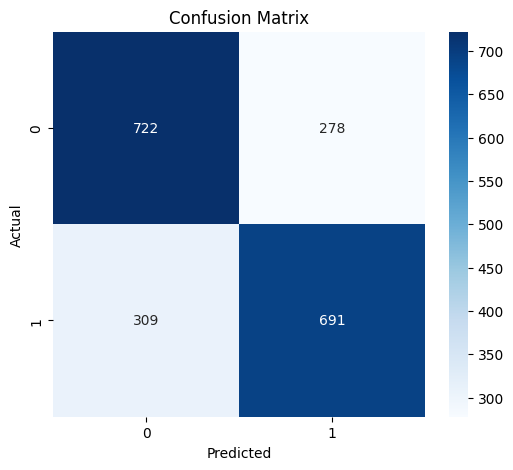

In [7]:
# evaluate on test set
y_pred = clf.predict(X_test)

evaluate_model(y_test, y_pred)

### Logistic Regression

In [8]:
clf = LogisticRegression(random_state=42, max_iter=1000)
clf.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


Accuracy: 0.728
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.75      0.73      1000
           1       0.74      0.71      0.72      1000

    accuracy                           0.73      2000
   macro avg       0.73      0.73      0.73      2000
weighted avg       0.73      0.73      0.73      2000



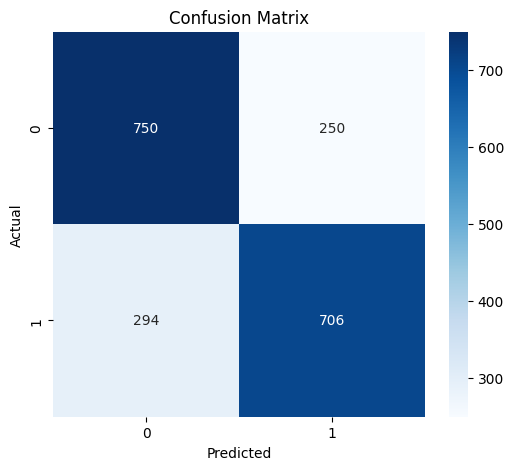

In [9]:
# evaluate on test set
y_pred = clf.predict(X_test)

evaluate_model(y_test, y_pred)

Logistic Regression performs better than Random Forest on the sentiment analysis task using SPPMI-SVD embeddings